- Dog & Ghost > quickdraw rnn model
- Pinhole xray > images MURA data
- ZX81 FlightSim > vector map data
- GDEM > RADAR > NOAA data 
- HFB > eevorg > nb zebrastack eevorg
- Fusion > nb zebrastack shifter ct mr
- theWheel
- ALGT
- dH


Hexagonal landmark placement
Self-position zebrastack


In [2]:
import tensorflow as tf
import numpy as np
from skimage.transform import warp
from skimage import img_as_ubyte
from scipy import ndimage
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.animation as animation
from IPython.display import HTML
import imageio
from typing import List
from itertools import islice
from pprint import pprint
from pathlib import Path
import random, os, math

In [3]:
def sum_neighbors(prev:List[int]):
    if len(prev) == 1:
        return [prev[0]]*2
    
    return [prev[0] + prev[1]*2] \
        + [sum(prev[n-1:n+1]) for n in range(1,len(prev)-1)] \
        + [sum(prev[-2:-1])] \
        + [prev[-1]]

def calculate_generations(gen0:List[int], rule:List[int]):
    gen = gen0
    while True:
        yield gen
        sum_gen = sum_neighbors(gen)
        max_value = max(sum_gen)
        rule = rule + [0] * (max_value-len(rule)+1) if max_value >= len(rule) else rule
        gen = list(map(lambda x:rule[x], sum_gen))
        
rule = [1,1,2,4,0,2,1,3,0]
gen_count = 16
gens = list(islice(calculate_generations([1],rule),gen_count))
gens[:10]

[[1],
 [1, 1],
 [4, 1, 1],
 [1, 2, 1, 1],
 [2, 4, 4, 1, 1],
 [0, 1, 0, 2, 1, 1],
 [2, 1, 1, 2, 4, 1, 1],
 [0, 4, 2, 4, 1, 2, 1, 1],
 [0, 0, 1, 1, 2, 4, 4, 1, 1],
 [1, 1, 1, 2, 4, 1, 0, 2, 1, 1]]

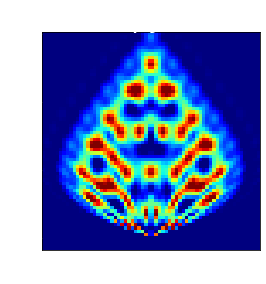

In [4]:
%matplotlib inline
zoo = {}
mpl.rcParams.update({'text.color' : 'white',
                     'axes.labelcolor' : 'white',
                     'ytick.color' : 'white',
                     'xtick.color' : 'white',
                     'font.size': 22})

def mirror_image(gens):
    width = max(len(gen) for gen in gens)
    rows = [gen + [0]*(width-len(gen)) for gen in gens]
    return np.array(rows, dtype=np.float32)

def bulb_warp(coords, scale=1.0, power=4.0):
    offset = np.array([[-np.max(coords[:,0]) / 2.0, -scale*4.0]] * coords.shape[0])
    coords = np.abs(coords + offset) * scale
    height_cubed = pow(np.max(coords[:,1]), power)
    bulb_width = 0.8 - np.power(coords[:,1], power) / height_cubed
    coords[:,0] = coords[:,0] / bulb_width
    return coords

def calculate_entropy(img):
    bins, _ = np.histogram(img)
    bins = bins / sum(bins)
    return sum([-b * math.log(b+1e-6) for b in bins])

def make_eevorg(gens, scale=4.0, power=4.0, add_to_zoo=True):
    mirror_img = mirror_image(gens)
    mirror_entropy = calculate_entropy(mirror_img)
    new_shape = (mirror_img.shape[0]*scale, 
                 mirror_img.shape[0]*scale)
    bulb_img = warp(mirror_img, bulb_warp, 
                    map_args={'scale':1.0/scale, 'power':power},
                    order=3,
                    output_shape=new_shape)
    return bulb_img, mirror_entropy

def show_zoom(bulb_img, entropy, axs):
    axs.set_title(f"entropy: {entropy:.2f}")
    axs.imshow(bulb_img, cmap='jet')

fig,axs = plt.subplots(1,1)
bulb_img, entropy = make_eevorg(gens, scale=4.0, power=4.0)
eevorg_dict = {'gens': gens, 
               'bulb_img': bulb_img,
               'entropy': entropy}
zoo[tuple(rule)] = eevorg_dict
show_zoom(bulb_img, entropy, axs)

Final rule = [1, 1, 1, 7, 0, 2, 0, 3, 1]
16 Eevorg in zoo


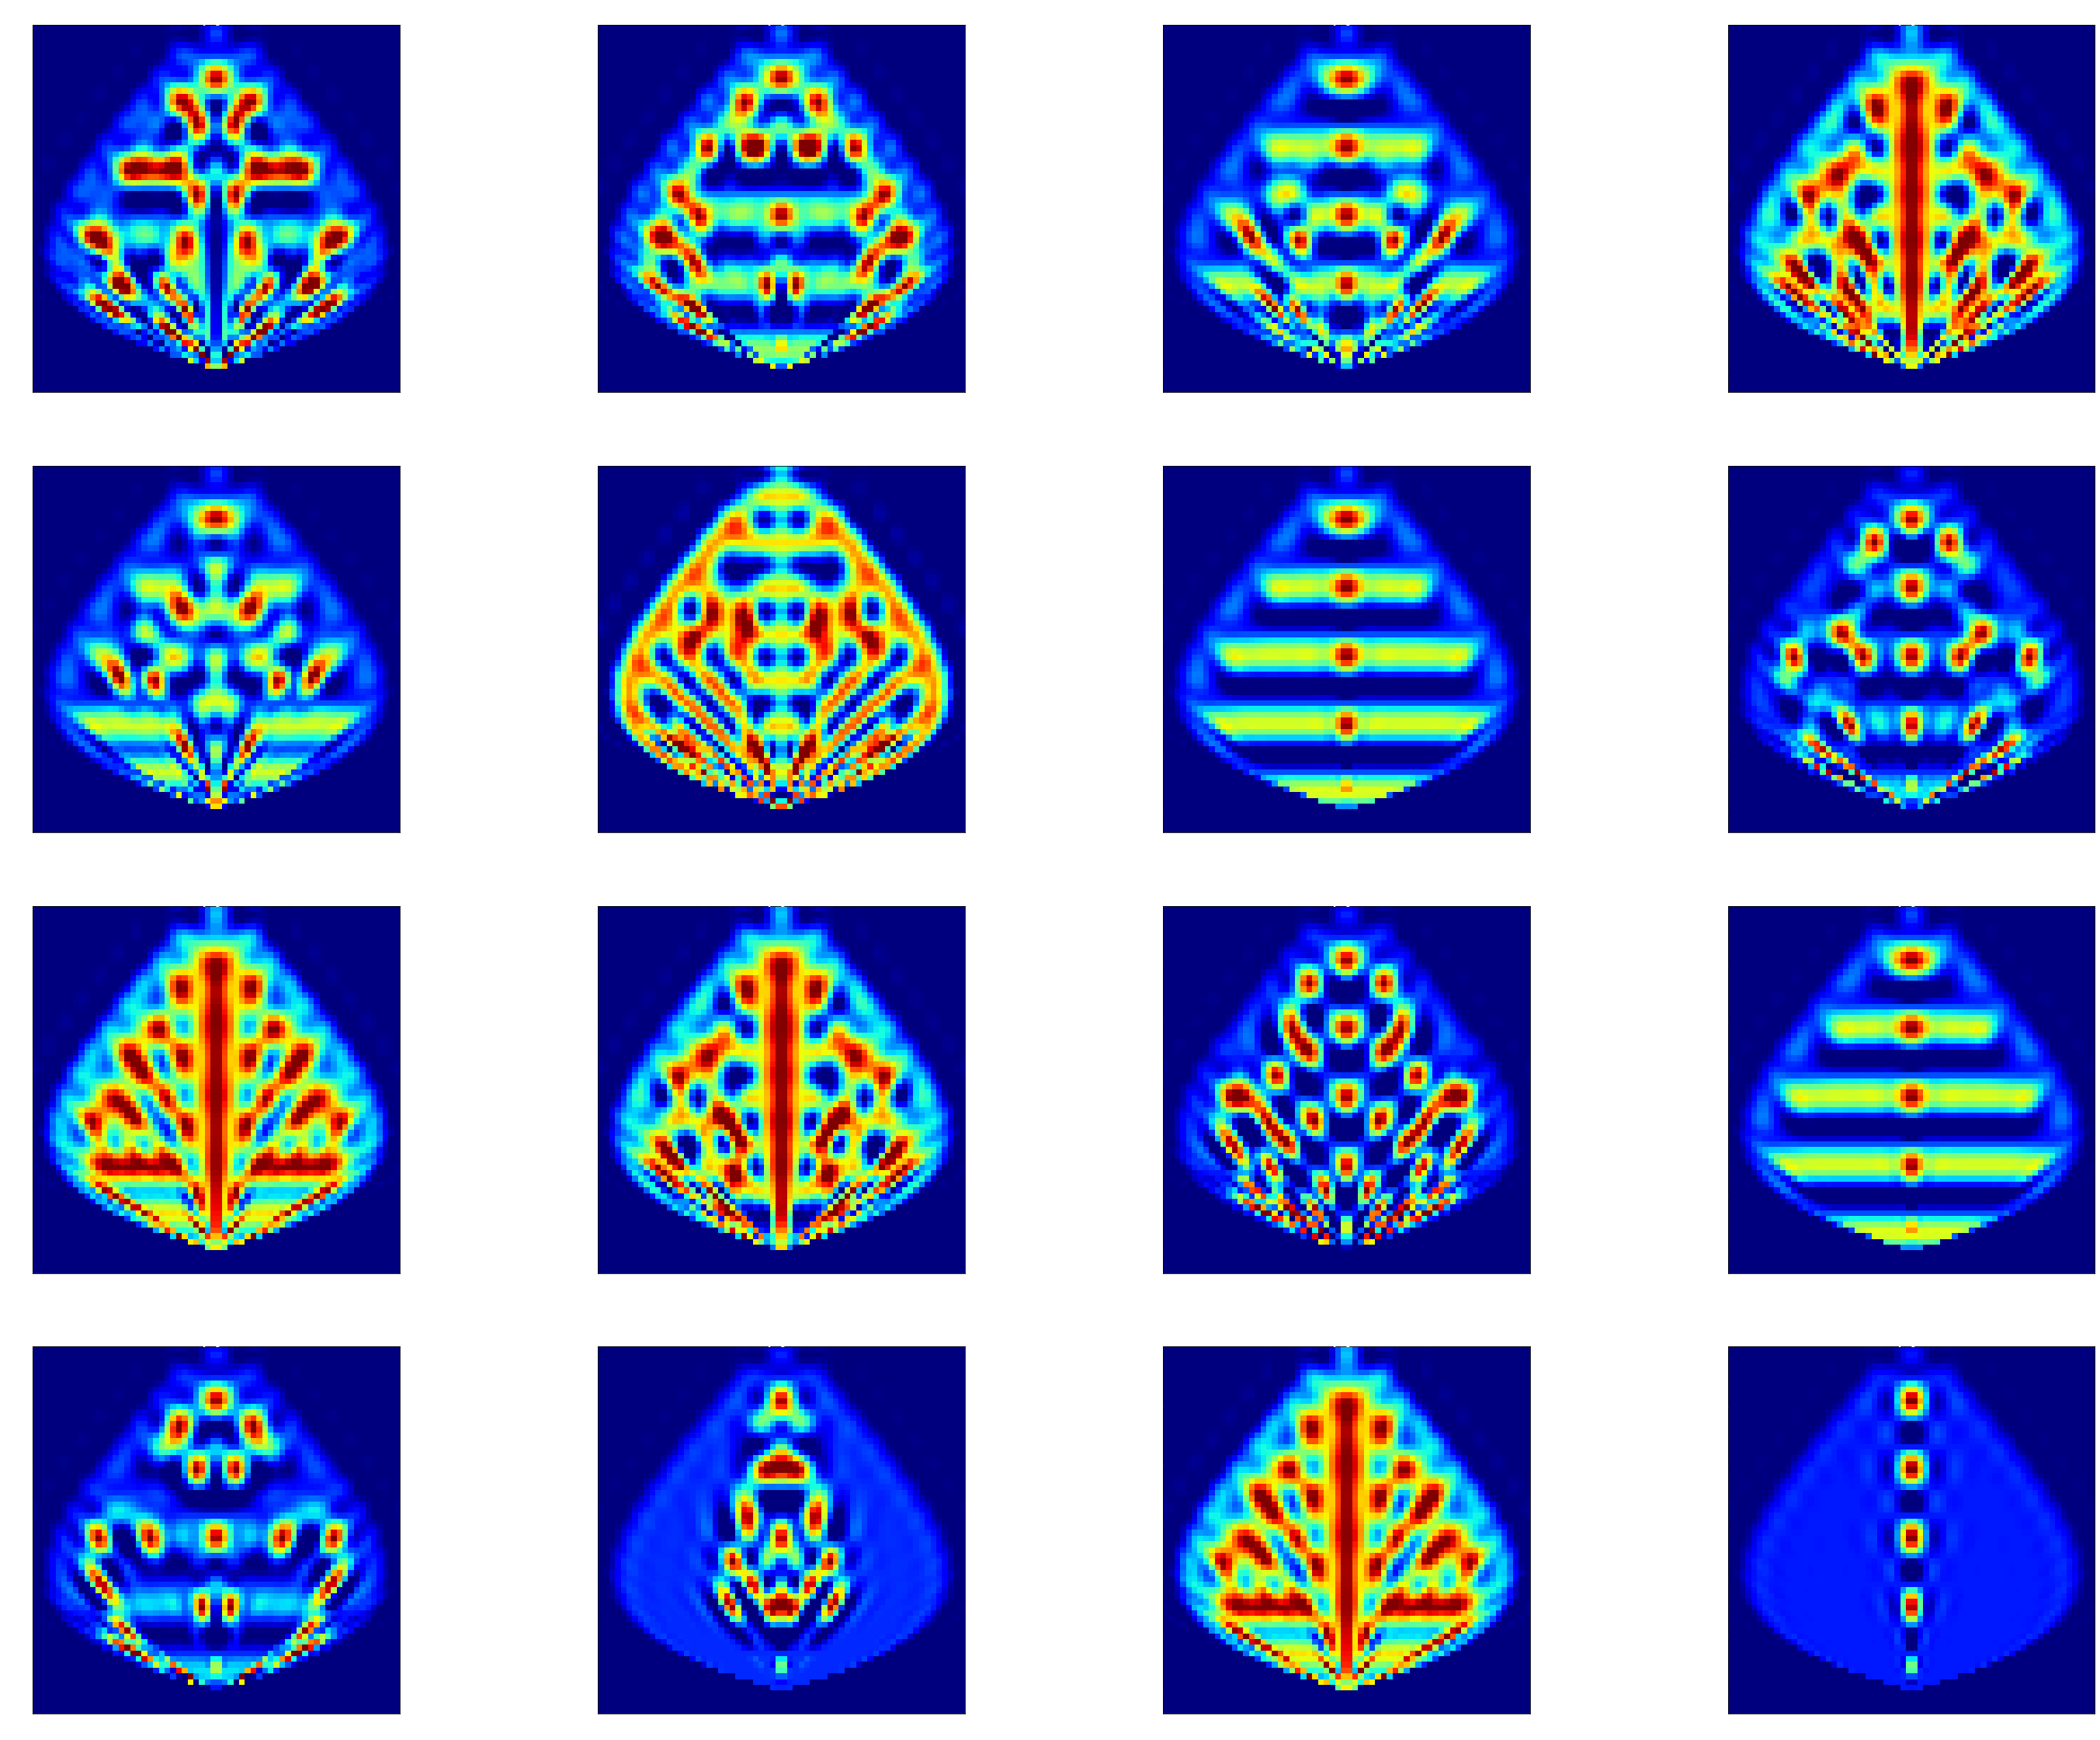

In [5]:
alpha, beta = 2.0, 5.0
use_beta = False

def mutate(rule:List[int], add_to_zoo=True):
    while True:
        pos = \
            int(float(len(rule)) * random.betavariate(alpha, beta)) \
                if use_beta else random.randint(0,len(rule)+1)

        while pos > len(rule)-1:
            rule = rule + [1]

        rule[pos] = abs(rule[pos]+random.choice([-1,1]))
        gens = list(islice(calculate_generations([1,0],rule),gen_count))
        bulb_img, entropy = make_eevorg(gens)
        if entropy > 0.1:
            eevorg_dict = {'gens': gens, 
                           'bulb_img': bulb_img,
                           'entropy': entropy}
            if add_to_zoo:
                zoo[tuple(rule)] = eevorg_dict
                
            return rule, eevorg_dict

# using the variable axs for multiple Axes
fig, axs = plt.subplots(4, 4, figsize=(50,40))
for row in range(axs.shape[0]):
    for col in range(axs.shape[1]):
        # randomly pick a rule from the zoo
        rule = list(random.choice(list(zoo)))
        rule, eevorg_dict = mutate(rule, add_to_zoo=True)
        zoo[tuple(rule)] = eevorg_dict
        show_zoom(eevorg_dict['bulb_img'], eevorg_dict['entropy'], axs[row][col])

print(f"Final rule = {rule}")
print(f"{len(zoo)} Eevorg in zoo")
# print(max([max(list(r)) for r in zoo.keys()]))
# print(max([len(r) for r in zoo.keys()]))

c:\python36\lib\site-packages\tensorflow\python\framework\constant_op.py:98: ComplexWarning: Casting complex values to real discards the imaginary part
  return ops.EagerTensor(value, ctx.device_name, dtype)


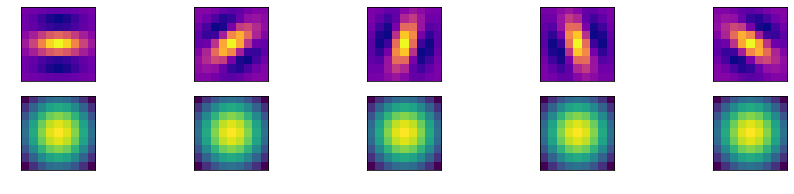

In [150]:
def kernels2tensor(kernels, dtype=tf.float32):
    kernels = np.moveaxis(np.expand_dims(kernels, axis=-1), 0,-1)
    return tf.constant(kernels, dtype=dtype)

def complex_exp(xs, ys, freq, angle_rad):
    return np.exp(freq * (xs*np.sin(angle_rad) + ys*np.cos(angle_rad)) * 1.0j)

def gauss(xs, ys, sigma):
    return (1 / (2 * np.pi * sigma**2)) \
        * np.exp(-(xs*xs + ys*ys) / (2.*sigma*sigma)) 

def make_meshgrid(sz=9):
    return np.meshgrid(np.linspace(-(sz//2), sz//2, sz),
                         np.linspace(-(sz//2), sz//2, sz))

def make_gabor_kernels(xs, ys, directions=3, freqs=[2.0, 1.0]):
    """ """
    angles_rad = [n * np.pi/float(directions) 
                  for n in range(directions)]    
    sine_kernels = kernels2tensor(
        [complex_exp(xs,ys,freq,angle_rad) 
             for freq in freqs
                for angle_rad in angles_rad])    
    sigmas = [2./freq for freq in freqs]
    gauss_kernels = kernels2tensor(
        [gauss(xs,ys,sigma) 
             for sigma in sigmas])
    gauss_kernels = np.repeat(gauss_kernels,
                              sine_kernels.shape[-1] // gauss_kernels.shape[-1], axis=-1)    
    
    bank = gauss_kernels * sine_kernels
    g0 = kernels2tensor([gauss(xs,ys,4./freqs[-1])])
    return tf.concat([bank, g0], -1)

directions = 5
freqs = [1.0]
xs,ys = make_meshgrid(sz=9)
gabor_kernels = make_gabor_kernels(xs, ys, directions=directions, freqs=freqs)
fig,axs = plt.subplots(len(freqs)+1, directions, figsize=(directions*3,len(freqs)*3))
for n in range(directions):
    for m in range(len(freqs)):
        img = tf.squeeze(gabor_kernels[...,0, m*directions+n])
        axs[m][n].imshow(tf.math.real(img), cmap='plasma')
g0 = tf.squeeze(gabor_kernels[...,0,-1])
for n in range(directions):
    axs[len(freqs)][n].imshow(tf.squeeze(g0))

In [151]:
def v1_v2(in_image, reshape_result = False):
    v1_response = \
        tf.nn.conv2d(in_image, 
                     tf.math.real(gabor_kernels), strides=1, padding='SAME') ** 2 \
            + tf.nn.conv2d(in_image, 
                           tf.math.imag(gabor_kernels), strides=1, padding='SAME') ** 2

    v1_response_sub = \
        tf.nn.max_pool(v1_response, (2,2), 
                       strides=2, padding='SAME')
    v1_response_sub = tf.squeeze(v1_response_sub)
    # tf.print(f"tf.squeeze(v1_response_sub): {v1_response_sub.shape}")
    v1_response_sub = tf.transpose(v1_response_sub, perm=[2,0,1])
    # tf.print(f"tf.transpose(v1_response_sub, perm=[2,0,1]) = {v1_response_sub.shape}")
    v1_response_sub = v1_response_sub[...,tf.newaxis]
    # print(v1_response_sub.shape)
    # tf.print(f"v1_response_sub[...,tf.newaxis]: {v1_response_sub.shape}")
    
    v2_response = \
        tf.nn.conv2d(v1_response_sub, 
                     tf.math.real(gabor_kernels), strides=1, padding='SAME') ** 2 \
            + tf.nn.conv2d(v1_response_sub, 
                           tf.math.imag(gabor_kernels), strides=1, padding='SAME') ** 2
    
    v2_response_sub = \
        tf.nn.max_pool(v2_response, (2,2), 
                       strides=2, padding='SAME')

    # v2_response_sub = tf.squeeze(v2_response_sub)
    # print(v2_response_sub.shape)    
    v2_response_sub = tf.transpose(v2_response_sub, perm=[3,0,1,2])
    # print(f"tf.transpose({v2_response_sub.shape}")
    v2_response_sub = tf.reshape(v2_response_sub, 
                                [v2_response_sub.shape[0] * v2_response_sub.shape[1], 
                                 v2_response_sub.shape[2],
                                 v2_response_sub.shape[3]])
    v2_response_sub = v2_response_sub[..., tf.newaxis]
    # print(v2_response_sub.shape)
    
    # print(v2_response_sub.shape)
    v4_response = \
        tf.nn.conv2d(v2_response_sub, 
                     tf.math.real(gabor_kernels), strides=1, padding='SAME') ** 2 \
            + tf.nn.conv2d(v2_response_sub, 
                           tf.math.imag(gabor_kernels), strides=1, padding='SAME') ** 2

    v4_response_sub = \
        tf.nn.max_pool(v4_response, (2,2), 
                       strides=2, padding='SAME')
    
    return v4_response_sub

(36, 8, 8, 6)


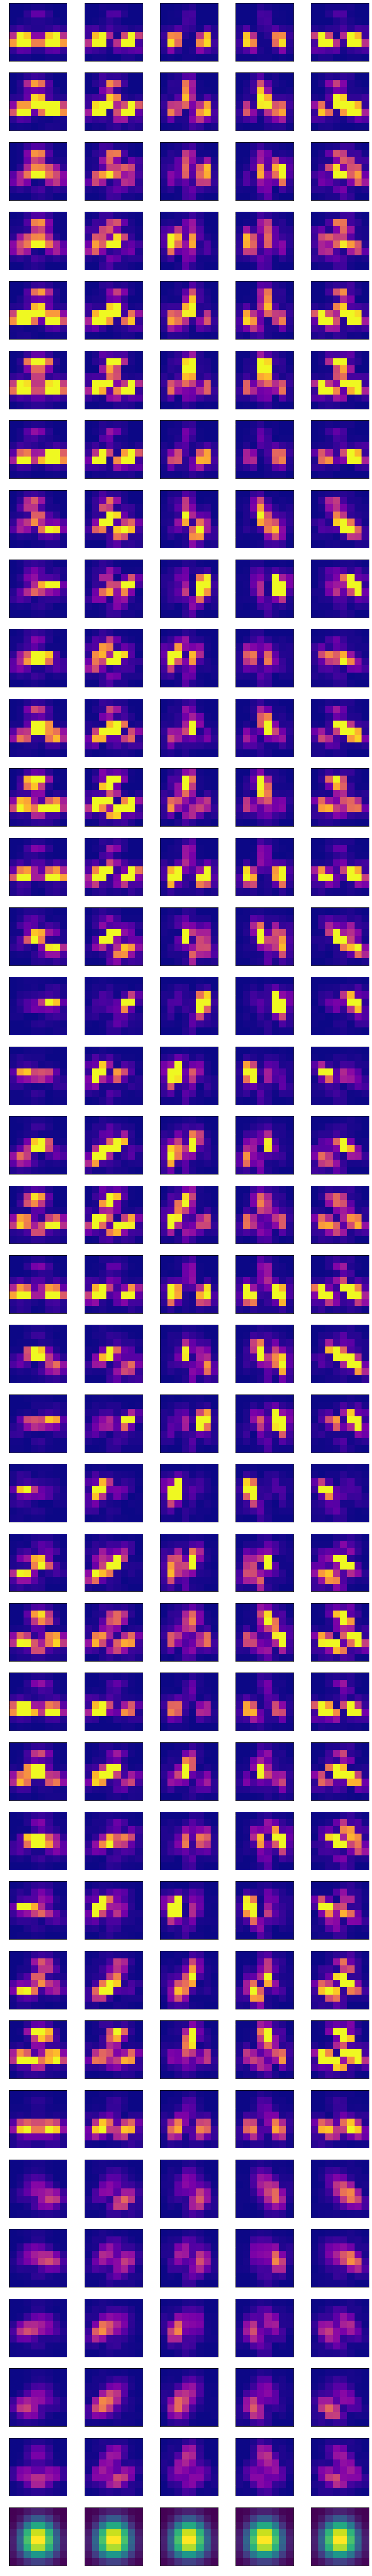

In [152]:
%matplotlib inline
rule1 = list(zoo)[23]
eevorg1 = zoo[rule1]

eevorg1_v2_response_sub = v1_v2(eevorg1['bulb_img'][tf.newaxis,...,tf.newaxis])
print(eevorg1_v2_response_sub.shape)

fig,axs = plt.subplots(eevorg1_v2_response_sub.shape[0]*len(freqs)+1, 
                       directions, figsize=(directions*3,
                                            eevorg1_v2_response_sub.shape[0]*len(freqs)*3))

for l in range(eevorg1_v2_response_sub.shape[0]):
    vmax = tf.reduce_max(eevorg1_v2_response_sub[l,...])
    
    for m in range(len(freqs)):
        for n in range(directions):
            img = tf.squeeze(eevorg1_v2_response_sub[l,...,m*directions+n])
            axs[m+(l)][n].imshow(tf.math.real(img), cmap='plasma', vmin=0., vmax=vmax/2.)
    g0 = tf.squeeze(eevorg1_v2_response_sub[l,...,-1])
    for n in range(directions):
        axs[len(freqs)+(l)][n].imshow(g0)

In [142]:
current_value = tf.Variable(0.5 * np.ones((1,sz,sz,1)), dtype=tf.float32)

vmax = tf.math.reciprocal(tf.reduce_max(eevorg1_v2_response_sub, axis=[1,2]))

def flatten_last(tensor, dims=4):
    return tf.reshape(tensor, (tensor.shape[0], tensor.shape[1], tensor.shape[2] * tensor.shape[3]))
    
def cross_entropy_loss(current, match):
    global vmax
    current_flattened = flatten_last(tf.transpose(current, perm=[3,0,1,2]))
    match_flattened = flatten_last(tf.transpose(match, perm=[3,0,1,2]))
    cross_entropy = tf.keras.losses.binary_crossentropy(match_flattened, current_flattened)
    loss = tf.tensordot(cross_entropy, vmax, axes=2)
    return loss

def cosine_loss(current, match):
    dot_prod = tf.tensordot(current, match, axes=4)
    loss = dot_prod / (tf.norm(current, ord='euclidean') * tf.norm(match, ord='euclidean'))
    return loss

def mse_loss(current, match):
    loss_per_bank = tf.reduce_mean((current - match) ** 2, axis=[1,2])
    loss = tf.tensordot(loss_per_bank, vmax, axes=2)
    return loss

loss_function = cross_entropy_loss
with tf.GradientTape() as tape:
    current_v2_response_sub = v1_v2(current_value)
    loss = loss_function(current_v2_response_sub, eevorg1_v2_response_sub)

grad = tape.gradient(loss, current_value)
# logging.info(f"Loss = {loss}, Gradient max = {np.max(grad)}")
optimizer = tf.optimizers.Adam(1e-3)
optimizer.apply_gradients(zip([grad], [current_value]))

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1>

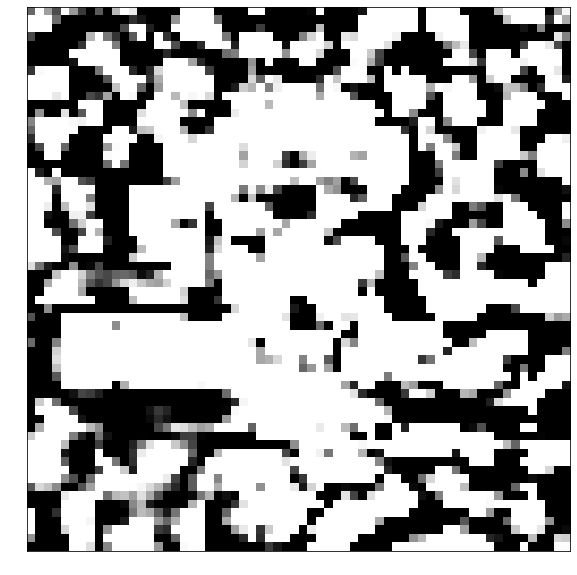

In [147]:
fig, ax = plt.subplots(figsize=(10,10))
im_axis = ax.imshow(np.squeeze(current_value.numpy()), 
                    cmap='gray', vmin=0., vmax=0.9)

def iterate(i):
    global grad, current_value
    for n in range(100):
        optimizer.apply_gradients(zip([grad], [current_value]))
        with tf.GradientTape() as tape:
            current_v2_response_sub = v1_v2(current_value)
            loss = loss_function(current_v2_response_sub, eevorg1_v2_response_sub)
        grad = tape.gradient(loss, current_value)
        
    # logging.info(loss)
    im_axis.set_data(np.squeeze(current_value.numpy()))

ani = animation.FuncAnimation(fig, iterate, frames=50)
HTML(ani.to_jshtml())

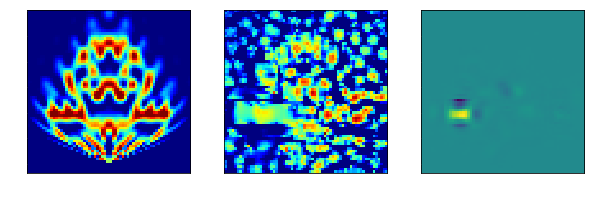

In [149]:
%matplotlib inline
learning_rate = 1e+3
optimizer = tf.optimizers.Adam()
# for n in range(1000):
#    optimizer.apply_gradients(zip([grad], [current_value]))
#    with tf.GradientTape() as tape:
#        current_out = mse_tf(current_value, gabor_kernels, eevorg1_out_sub)
        # tf.print(f"loss = {current_out}   ")
#    grad = tape.gradient(current_out, current_value)
    
fig, axs = plt.subplots(1,3,figsize=(10,3))
axs[0].imshow(tf.reshape(eevorg1['bulb_img'], 
                         (sz,sz)), cmap='jet', vmin=0.)
axs[1].imshow(tf.reshape(current_value, (sz,sz)), cmap='jet', vmin=0.)
axs[2].imshow(tf.reshape(grad, (sz,sz)))
plt.show()

In [ ]:
png_location = Path(os.environ['DATA_TEMP']) / 'eevorg' / 'original_png'
png_location.mkdir(parents=True, exist_ok=True)
print(png_location)

value2char = ['0','1','2','3','4','5','6','7','8','9','0','a','b','c','d','e','f']
rule2fn = lambda rule: ''.join([value2char[v] for v in rule])
rule2fn(rule)